In [16]:
import networkx as nx
import numpy as np
from random import random

In [17]:
G = nx.planted_partition_graph(3, 5, 0.7, 0.05, seed=40)

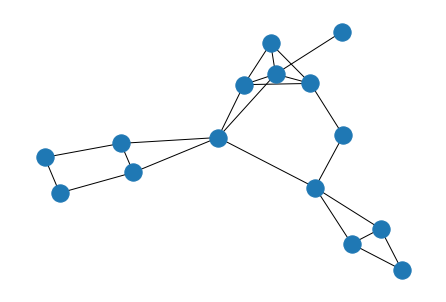

In [18]:
nx.draw(G)

In [22]:
# bigclam algorithm taken from https://github.com/RobRomijnders/bigclam
def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad

def train(A, C, iterations = 100):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C)

    for n in range(iterations):
        for person in range(N):
            grad = gradient(F, A, person)

            F[person] += 0.005*grad

            F[person] = np.maximum(0.001, F[person]) # F should be nonnegative
        ll = log_likelihood(F, A)
    return F, log_likelihood(F, A)

In [23]:
A = nx.to_numpy_array(G)

In [29]:
likelihood = []
preference_matrix = []
for i in range(100):
    F, ll = train(A, 3)
    likelihood.append(ll)
    preference_matrix.append(F)
best = np.argmax(likelihood)
pred = np.argmax(preference_matrix[best], 1)

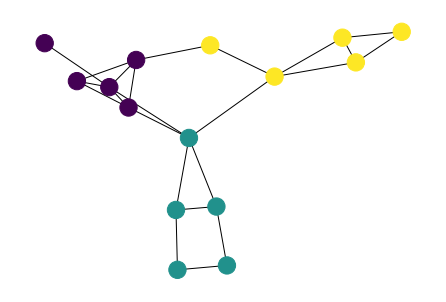

In [30]:
pos = nx.spring_layout(G)
nx.draw(G, pos = pos, node_color=pred)